Завдання: Написати програму що реалізує згорткову нейронну мережу AlexNet для розпізнавання об’єктів з датасету ImageNet

Підготовка до реалізації

AlexNet Архітектура:
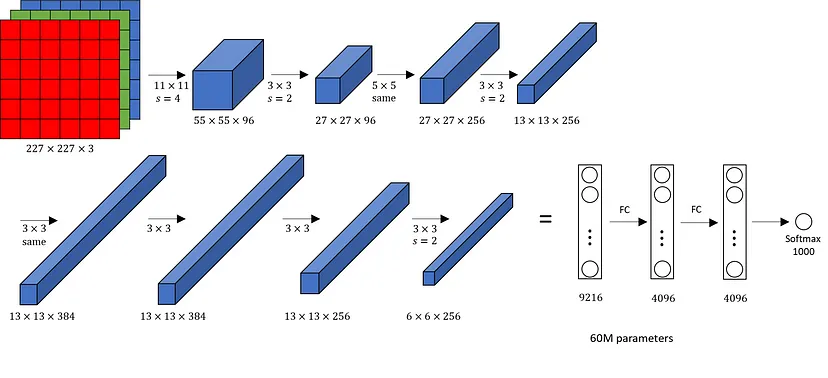     

AlexNet Summary
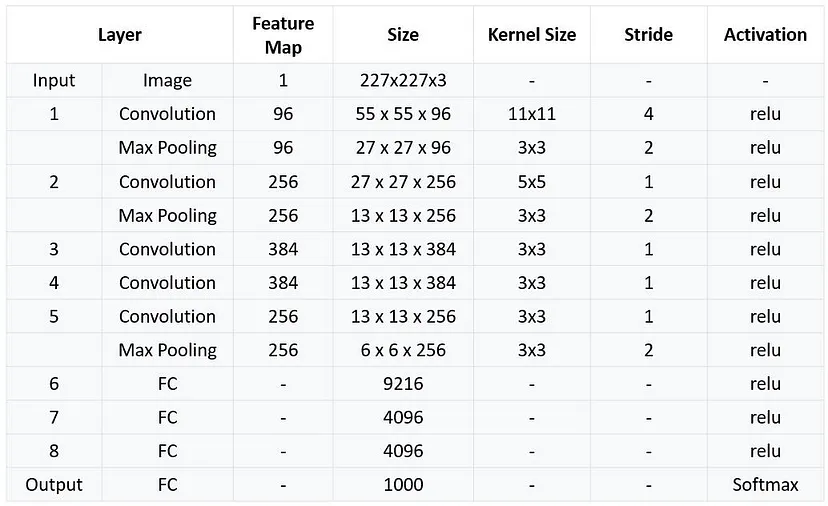

In [ ]:
import scipy.ndimage as nd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

import os, sys, wget
from zipfile import ZipFile



In [ ]:

url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
tiny_imgdataset = wget.download('http://cs231n.stanford.edu/tiny-imagenet-200.zip', out = os.getcwd())
for file in os.listdir(os.getcwd()):
    if file.endswith(".zip"):
        zip = ZipFile(file)
        zip.extractall()
    else:
        print("not found")

In [2]:
from keras import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 
        
        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))
        
        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [28]:
num_classes = 3  
model = AlexNet((227, 227, 3), num_classes)


# training parameters
EPOCHS = 10
BATCH_SIZE = 32
image_height = 227
image_width = 227

# Шляхи до директорій для тренування та валідації для кожного класу
train_dir = "./imagenetPart/train"
valid_dir = "./imagenetPart/validation"

# Зазначення назв класів
class_names = ['goldfish', 'lizard', 'frog']


train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)

# Зміна параметрів генераторів для відповідних кількостей класів
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    classes=class_names)

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    classes=class_names)

train_num = train_generator.samples
valid_num = valid_generator.samples

Found 1500 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [29]:
model.summary()
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_num // BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_num // BATCH_SIZE,
                    verbose=1)
print(history.history['accuracy'])  # точність на тренувальному наборі
print(history.history['val_accuracy'])  # точність на валідаційному наборі

Model: "alex_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 384)       1

Візуалізація прогнозів моделі для зображень

Тут використовується попередньо навчена модель для передбачення класів (золота рибка, ящірка, жаба) для зображень з валідаційного набору даних. Потім виводиться візуалізація цих зображень разом з підписами, де правильні передбачення відзначені синім текстом, а неправильні - червоним. Відображення здійснюється у вигляді сітки 2x4 для перегляду восьми зображень.

1/1 [==============================] - 0s 361ms/step


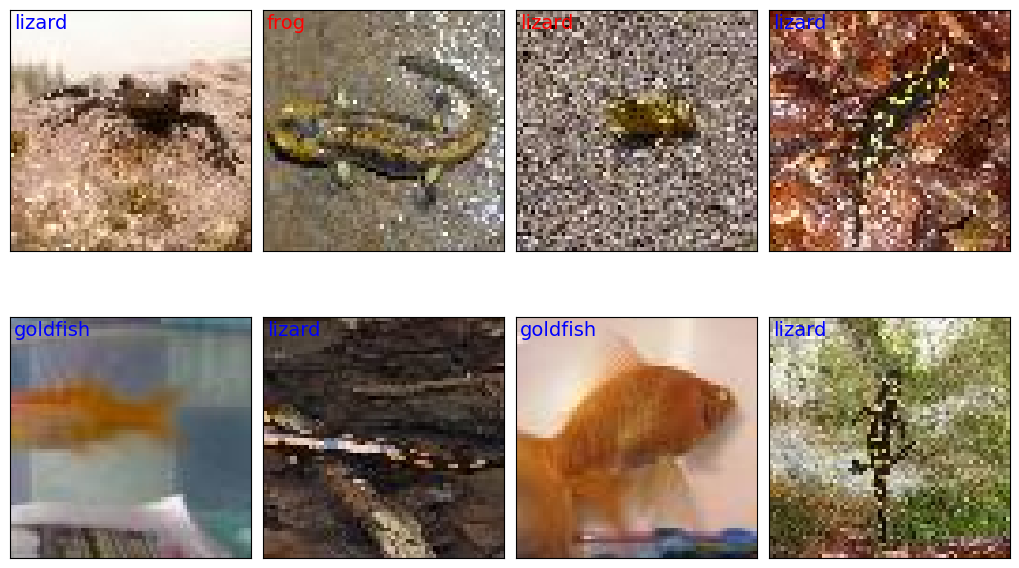

In [31]:
class_names = ['goldfish', 'lizard', 'frog']

x_valid, label_batch  = next(iter(valid_generator))
predict_x=model.predict(x_valid) 
prediction_values=np.argmax(predict_x,axis=1)

# set up the figure
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the images: each image is 227x227 pixels
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(x_valid[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
  
    if prediction_values[i] == np.argmax(label_batch[i]):
        # label the image with the blue text
        ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)
    else:
        # label the image with the red text
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)

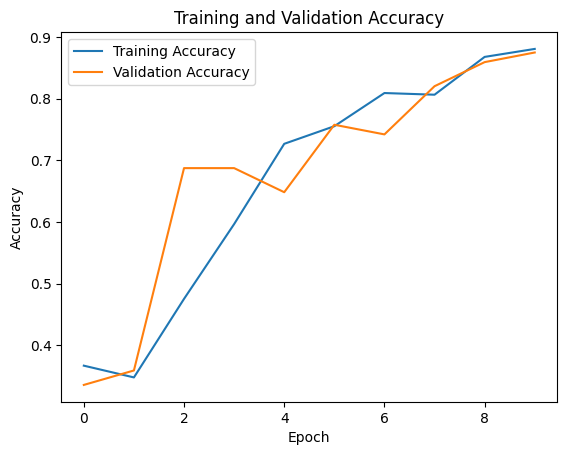

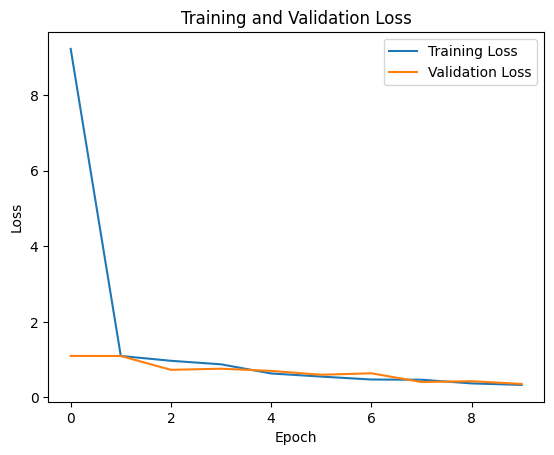

In [30]:
# Виведення графіка точності
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Виведення графіка втрат
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()